In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [25]:
# Define the style transfer model
def create_model(input_shape=(None, None, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    content_layer = 'block5_conv3'

    style_outputs = [base_model.get_layer(layer).output for layer in style_layers]
    content_output = base_model.get_layer(content_layer).output

    model = models.Model(inputs=base_model.input, outputs=style_outputs + [content_output])
    return model

In [26]:
# Define loss functions
def content_loss(target, generated):
    return tf.reduce_mean(tf.square(target - generated))

def style_loss(style, generated):
    style_gram = tf.linalg.einsum('bijc,bijd->bcd', style, style)
    generated_gram = tf.linalg.einsum('bijc,bijd->bcd', generated, generated)
    loss = tf.reduce_mean(tf.square(style_gram - generated_gram))
    return loss

In [27]:
# Total loss with instance normalization
def total_loss(style_targets, content_targets, style_outputs, content_output, alpha=1e-4, beta=1):
    style_loss_val = sum([style_loss(style, generated) for style, generated in zip(style_targets, style_outputs)])
    content_loss_val = content_loss(content_targets, content_output)

    # Instance normalization for style loss
    style_loss_val += tf.reduce_sum([tf.reduce_mean(tf.image.per_image_standardization(style) - tf.image.per_image_standardization(generated)) for style, generated in zip(style_targets, style_outputs)])

    total_loss = alpha * style_loss_val + beta * content_loss_val
    return total_loss


In [28]:
# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array / 255.0


In [29]:
# Load and preprocess style and content images
# style_image_path = 'path_to_style_image.jpg'
# content_image_path = 'path_to_content_image.jpg'
style_image_path = '/content/background.webp'
content_image_path = '/content/rose.jpeg'

style_image = load_and_preprocess_image(style_image_path)
content_image = load_and_preprocess_image(content_image_path)


In [30]:
# Create the style transfer model with dynamic input shape
model = create_model(input_shape=content_image.shape[1:])


In [31]:
# Extract features from style and content images
style_targets = model(style_image)[:-1]
content_target = model(content_image)[-1]

In [36]:
# Create the generated image as a variable for optimization
generated_image = tf.Variable(content_image.numpy())

# Define optimizer
optimizer = optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [37]:
# Training loop
epochs = 20
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        style_outputs = model(generated_image)[:-1]
        content_output = model(generated_image)[-1]

        loss = total_loss(style_targets, content_target, style_outputs, content_output)

    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])


In [39]:
# Convert the tensor to a PIL Image
result_image_pil = tf.keras.preprocessing.image.array_to_img(result_image)

# Save the PIL Image as a PNG file
result_image_pil.save('output_image.png')

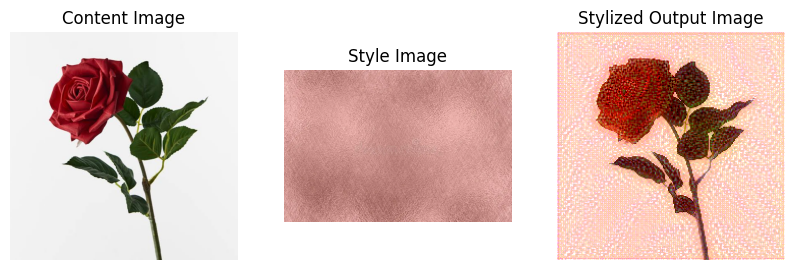

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the original content, style, and output images
content_image = mpimg.imread(content_image_path)
style_image = mpimg.imread(style_image_path)
output_image = mpimg.imread('output_image.png')

# Plot the images
plt.figure(figsize=(10, 5))

# Original Content Image
plt.subplot(1, 3, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

# Style Image
plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

# Stylized Output Image
plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title('Stylized Output Image')
plt.axis('off')

plt.show()
